Newton's Method for Logistic Regression is implemented in [newton.py](https://github.com/charliemoore00/charliemoore00.github.io/blob/main/posts/newtons-method/newton.py)

In [385]:
%load_ext autoreload
%autoreload 2
from newton import LogisticRegression, GradientDescentOptimizer, NewtonOptimizer
import torch
from matplotlib import pyplot as plt # type: ignore

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Introduction

This blog posts expands on implementing logistic regression and gradient descent with momentum. This post introduces Newton's Method as an alternative to gradient descent optimization.

## Part A: Implement `NewtonOptimizer`

Newton’s Method is a second-order optimization technique. This means that it requires information about the second derivatives of the loss function  as well as the first derivatives. Here’s how Newton’s method works:

1. We compute the usual gradient $\nabla L(\mathbf{w})$, which is the vector of first derivatives of $L$.

2. We also compute the Hessian Matrix, which is the matrix of second derivatives of $L$. For logistic regression, the Hessian is the matrix $\mathbf{H}(\mathbf{w}) \in \mathbb{R}^{p \times p}$ with entries
\begin{aligned}
h_{ij}(\mathbf{w}) = \sum_{k = 1}^n x_{ki}x_{kj}\sigma(s_k)(1-\sigma(s_k))\;
\end{aligned}
To compute this matrix, we'll use the formula $\mathbf{H}(\mathbf{w}) = \mathbf{X}^T\mathbf{D}(\mathbf{w})\mathbf{X}$ where $D$ is the diagonal matrix with entries $d_{kk}(\mathbf{w}) = \sigma(s_k)(1-\sigma(s_k))$.

3. Once we know how to calculate the gradient and the Hessian, we repeat the update
\begin{aligned}
w \gets w - \alpha \mathbf{H}(\mathbf{w})^{-1} \nabla L (\mathbf{w})\;
\end{aligned}
until convergence. Here, $\alpha > 0$ is the learning rate and $\mathbf{H}(\mathbf{w})^{-1}$ is the matrix inverse of the Hessian Matrix.


The newton.py file linked at the top implements a `NewtonOptimizer` class that uses Newton's method to estimate **w** for a `LogisticRegression` model.

## Part B: Experimenting

1. When $\alpha$ is chosen appropriately, Newton's method converges to the correct choice of **w**.
2. Under at least some circumstances, Newton's method can converge *much* faster than standard gradient descent, in the sense of decreasing the empirical risk.
3. If $\alpha$ is too large, Newton's method fails to converge.

### Generating Experimental Data

Here is a method to generate data. The parameters are:

- `n_points`: the number of points
- `p_dims`: the number of features
- `noise`: the difficulty of the classification problem

In [386]:
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

X_rand, y_rand = classification_data(noise = 0.5)

### Training the Model

We'll create train and plot methods for both Newton's method and regular Gradient Descent to show differences.

#### Gradient Descent Training

In [387]:
def train_and_plot_gradient_descent(X, y, alpha, beta, iterations=100):
    # initialize a logistic regression and gradient descent optimizer
    LR = LogisticRegression() 
    opt = GradientDescentOptimizer(LR)
    # to keep track of the loss to plot it
    loss_vec = []

    for _ in range(iterations):

       # keep track of the loss over time. 
        loss = LR.loss(X, y)
        loss_vec.append(loss)
        # use GradientDescentOptimizer's step function
        opt.step(X, y, alpha, beta)

    # plot the loss
    plt.plot(torch.arange(1, len(loss_vec) +1), loss_vec, color="black")
    plt.semilogx()
    labs = plt.gca().set(xlabel = "Number of Gradient Descent iterations", ylabel="loss")

#### Newton's Method Training

In [388]:
def train_and_plot_newton_optimizer(X, y, alpha, iterations=100):
    # initialize a logistic regression and gradient descent optimizer
    LR = LogisticRegression() 
    opt = NewtonOptimizer(LR)
    # to keep track of the loss to plot it
    loss_vec = []

    for _ in range(iterations):
       # keep track of the loss over time. 
        loss = LR.loss(X, y)
        loss_vec.append(loss)
        # use NewtonOptimizer's step function
        opt.step(X, y, alpha)

    # plot the loss
    plt.plot(torch.arange(1, len(loss_vec) +1), loss_vec, color="black")
    plt.semilogx()
    labs = plt.gca().set(xlabel = "Number of Newton Optimizer iterations", ylabel="loss")

#### **Experiment #1:** When $\alpha$ is chosen appropriately, Newton's method converges to the correct choice of **w**.

First, let's generate some data:

In [389]:
X_exp, y_exp = classification_data(n_points = 3000, noise = 0.5, p_dims = 2)

Then we'll train and plot our data with an $\alpha$ value of 200:

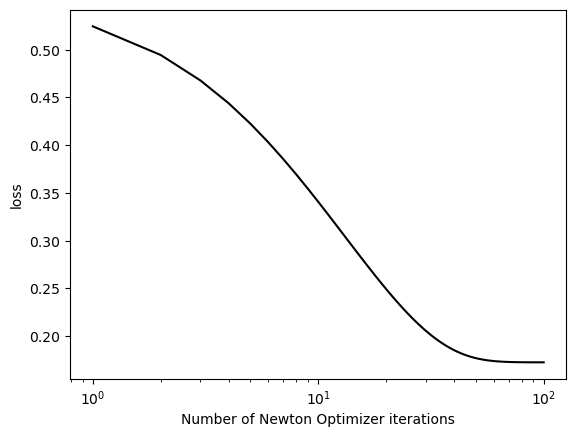

In [390]:
train_and_plot_newton_optimizer(X_exp, y_exp, 200, iterations = 100)

We can see of Logistic Regression with a Newton Optimizer does indeed **converge** within 100 iterations!

#### **Experiment #2:** Under at least some circumstances, Newton's method can converge *much* faster than standard gradient descent

Let's train and plot both gradient descent **and** Newton's method on the same data as before, but on 1000 iterations:

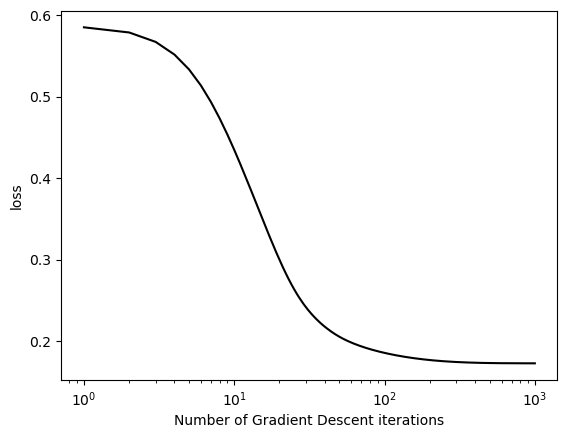

In [391]:
# gradient descent
train_and_plot_gradient_descent(X_exp, y_exp, 0.1, 0.9, iterations = 1000)

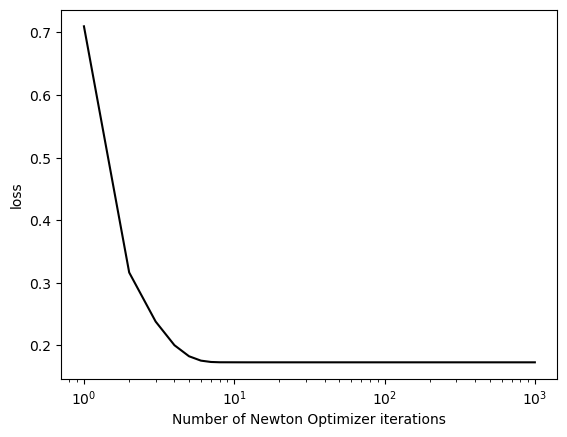

In [392]:
# Newton's method
train_and_plot_newton_optimizer(X_exp, y_exp, 2000, iterations=1000)

We can see that while it takes gradient descent between 100-1000 iterations to converge, it takes Newton's method **less than 10**. This is over a 10x speedup! But keep in mind this data has a low number of features.

#### **Experiment #3:** If $\alpha$ is too large, Newton's method fails to converge.

Let's generate some data of higher dimensionality:

In [409]:
X, y = classification_data(n_points = 100, noise = 0.5, p_dims = 2)
train_and_plot_newton_optimizer(X, y, 2000, iterations=1000)

_LinAlgError: linalg.inv: The diagonal element 1 is zero, the inversion could not be completed because the input matrix is singular.

# REQUEST FOR HELP:

While trying several combinations of different values for n_points, p_dims, and alpha, I am unable to create a plot that doesn't converge. I am often receiving the following error message:

**_LinAlgError: linalg.inv: The diagonal element 1 is zero, the inversion could not be completed because the input matrix is singular.**

Is my implementation of NewtonOptimizer at fault? Or have I just not found a working combination of those variables?